# Gaussian Mixture Models (GMM) Step-by-Step Derivation

Gaussian Mixture Models (GMMs) are probabilistic models that assume all the data points are generated from a mixture of several Gaussian distributions with unknown parameters. Here is a step-by-step derivation of the GMM and its Expectation-Maximization (EM) algorithm.





In [253]:
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs


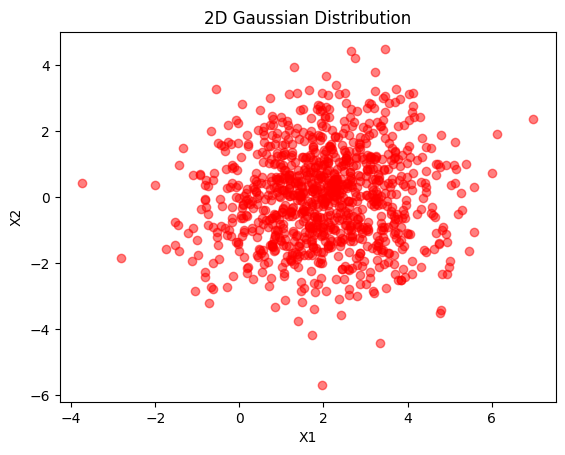

In [254]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Define the mean vector and covariance matrix
mean = np.array([2, 0])  # Example for 2-dimensional Gaussian
cov = np.array([[2, 0.1],
                [0.1, 2]])  # Example covariance matrix for 2D

# Create a multivariate normal distribution
rv = multivariate_normal(mean, cov)

# Generate random samples from the distribution
num_samples = 1000
samples = rv.rvs(size=num_samples)

# Plot the samples if the distribution is 2-dimensional
if len(mean) == 2:
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, c='r')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('2D Gaussian Distribution')
    plt.show()

In [299]:
def plot_multiple_contours(means, covs, X):
    # Create a figure
    plt.figure(figsize=(10, 8))

    # Determine the overall plotting range
    min_x, min_y = np.inf, np.inf
    max_x, max_y = -np.inf, -np.inf
    for mean, cov in zip(means, covs):
        min_x = min(min_x, mean[0] - 3*np.sqrt(cov[0, 0]))
        max_x = max(max_x, mean[0] + 3*np.sqrt(cov[0, 0]))
        min_y = min(min_y, mean[1] - 3*np.sqrt(cov[1, 1]))
        max_y = max(max_y, mean[1] + 3*np.sqrt(cov[1, 1]))

    # Create a grid of points
    x, y = np.mgrid[min_x:max_x:.01, min_y:max_y:.01]
    pos = np.dstack((x, y))

    # Plot contours for each Gaussian distribution
    for i, (mean, cov) in enumerate(zip(means, covs)):
        rv = multivariate_normal(mean, cov)
        z = rv.pdf(pos)
        plt.contour(x, y, z, levels=10, cmap='inferno')

    # Plot 2D scattered dataset
    plt.scatter(X[:, 0], X[:, 1], s=40)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title('GMM Plot')
    plt.colorbar()
    plt.axis('equal')
    plt.show()

def plot_multiple_contours_gif(means, covs, X, iter):
    # Create a figure
    plt.figure(figsize=(10, 8))

    # Determine the overall plotting range
    min_x, min_y = np.inf, np.inf
    max_x, max_y = -np.inf, -np.inf
    for mean, cov in zip(means, covs):
        min_x = min(min_x, mean[0] - 3*np.sqrt(cov[0, 0]))
        max_x = max(max_x, mean[0] + 3*np.sqrt(cov[0, 0]))
        min_y = min(min_y, mean[1] - 3*np.sqrt(cov[1, 1]))
        max_y = max(max_y, mean[1] + 3*np.sqrt(cov[1, 1]))

    # Create a grid of points
    x, y = np.mgrid[min_x:max_x:.01, min_y:max_y:.01]
    pos = np.dstack((x, y))

    # Plot contours for each Gaussian distribution
    for i, (mean, cov) in enumerate(zip(means, covs)):
        rv = multivariate_normal(mean, cov)
        z = rv.pdf(pos)
        plt.contour(x, y, z, levels=10, cmap='inferno')

    # Plot 2D scattered dataset
    plt.scatter(X[:, 0], X[:, 1], s=40)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title('GMM Plot')
    plt.colorbar()
    plt.axis('equal')
    plt.title('GMM Iteration')
    plt.savefig(f"iteration_images/iter_{iter}")
    plt.close()

#### Generating a random dataset

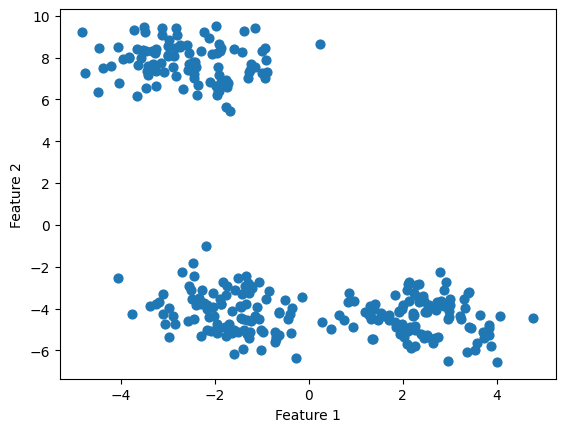

In [281]:
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.90)
plt.scatter(X[:, 0], X[:, 1], s=40)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

#### Generate N random 2-dimensional Gaussian Distribution

In [282]:
def generate_gaussian_parameters(n, dim):
    '''generates a random mean, covariance and weight for Gaussian distributions'''
    mean_vectors = []
    cov_matrices = []
    # considering each cluster to have equal number of data
    mixture_weights = [1/n]*n
    for _ in range(n):
        mean = 5 * np.random.rand(dim)
        A = np.random.rand(dim, dim)
        cov = np.dot(A, A.T)  # Create a positive semi-definite matrix
        mean_vectors.append(mean)
        # cov_matrices.append(cov)
        cov_matrices.append(np.array([[1,0],
                                      [0,1]]))
    return mean_vectors, cov_matrices, np.array(mixture_weights)

In [283]:
# Generating 4 random 2 dimensional Gaussian Distributions
mean, cov, mix_weight = generate_gaussian_parameters(3,2)

In [284]:
mix_weight

array([0.33333333, 0.33333333, 0.33333333])

#### Note:
- Weight is nothing but it tells us that if we have 3 clusters then how many points belong to each cluster out of the total number of points (num_points_per_cluster/num_of_data_points).
- For simplicity it is considered that each cluster have equal number of data points

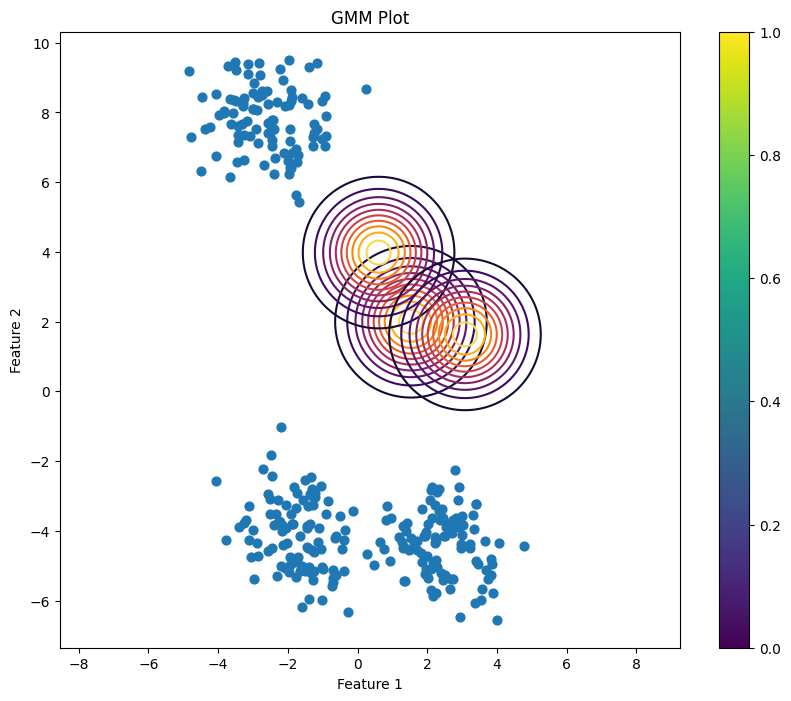

In [285]:
# plottin the gaussian curves and the data set 
plot_multiple_contours(mean, cov, X)

- We see that 3 random Gaussian Distributions are generated

#### Expectation Step: Find the likelihood of each point belonging to each dataset

In [261]:
def calc_responsibillities(mean, cov, mix_weight, X):
    '''Calculates the likelihood/responsibility of each
    data point belonging to each cluster
    Output Shape = number of data points X num of clusters'''
    likelihoods = []
    for mean, cov in zip(mean, cov):
        rv = multivariate_normal(mean, cov)
        temp_likelihood = rv.pdf(X)
        likelihoods.append(temp_likelihood)
    responsibilities = (np.array(likelihoods).T) * mix_weight
    return responsibilities/np.sum(responsibilities,axis = 1, keepdims=True)


In [262]:
responsibilities = calc_responsibillities(mean, cov, mix_weight, X)
responsibilities.shape

(300, 3)

In [263]:
responsibilities[:3]

array([[9.99995884e-01, 4.11430101e-06, 1.25427738e-09],
       [8.25821174e-05, 2.88002817e-01, 7.11914601e-01],
       [9.99971775e-01, 2.81972190e-05, 2.75086822e-08]])

In [264]:
np.sum(responsibilities, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

- We can observe that the sum of responsibilities for a data point is one if we sum them across all the clusters
- The scores are normalized

#### Maximization Step: Update the mean and covariance matrix

In [265]:
def update_parameters(responsibilities, mix_weight, mean, cov, X):
    '''updates the parameters of the gaussian curves'''
    n, d = X.shape
    eff_num_points = np.sum(responsibilities, axis=0)
    mix_weight = eff_num_points / np.sum(eff_num_points)
    mean = (responsibilities.T @ X) / eff_num_points.reshape(-1, 1)
    # TO DO: Covariance update
    # cov = []
    # for k in range(len(mean)):
    #     X_centered = X - mean[k]
    #     gamma_diag = np.diag(responsibilities[:, k])
    #     cov_k = np.dot(gamma_diag,np.dot(X_centered,X_centered.T)) / eff_num_points[k]
    #     cov.append(cov_k)
    return mix_weight, mean, cov

In [266]:
update_parameters(responsibilities, mix_weight, mean, cov, X)

(array([0.66669643, 0.05467536, 0.27862822]),
 array([[-3.37237277,  2.6387814 ],
        [ 4.31571859,  6.02571647],
        [ 5.19348855,  5.86424574]]),
 [array([[1, 0],
         [0, 1]]),
  array([[1, 0],
         [0, 1]]),
  array([[1, 0],
         [0, 1]])])

#### Complete Code

In [286]:
import numpy as np
from scipy.stats import multivariate_normal

def generate_gaussian_parameters(n, dim):
    mean_vectors = []
    cov_matrices = []
    mixture_weights = [1/n]*n
    for _ in range(n):
        mean = 5 * np.random.rand(dim)
        A = np.random.rand(dim, dim)
        cov = np.dot(A, A.T)  # Create a positive semi-definite matrix
        mean_vectors.append(mean)
        # cov_matrices.append(cov)
        cov_matrices.append(np.array([[1,0],
                                      [0,1]]))
    return mean_vectors, cov_matrices, np.array(mixture_weights)

def calc_responsibillities(mean, cov, mix_weight, X):
    '''Calculates the responsibilities for each data point'''
    likelihoods = []
    for m, c in zip(mean, cov):
        rv = multivariate_normal(m, c)
        temp_likelihood = rv.pdf(X)
        likelihoods.append(temp_likelihood)
    responsibilities = (np.array(likelihoods).T) * mix_weight
    if X.shape[0]>1:
        return responsibilities / np.sum(responsibilities, axis=1, keepdims=True)
    return responsibilities


# def update_parameters(responsibilities, mix_weight, mean, cov, X):
#     '''Updates the parameters of the Gaussian components'''
#     n, d = X.shape
#     eff_num_points = np.sum(responsibilities, axis=0)
#     mix_weight = eff_num_points / np.sum(eff_num_points)
#     mean = (responsibilities.T @ X) / eff_num_points.reshape(-1, 1)

#     cov = []
#     for k in range(len(mean)):
#         X_centered = X - mean[k]
#         gamma_diag = np.diag(responsibilities[:, k])
#         cov_k = np.dot(X_centered.T, np.dot(gamma_diag, X_centered)) / eff_num_points[k]
#         # Ensure covariance matrix is symmetric positive definite
#         cov_k = (cov_k + cov_k.T) / 2  # Symmetrize
#         min_eig = np.min(np.linalg.eigvals(cov_k))
#         if min_eig < 0:
#             cov_k -= 10 * min_eig * np.eye(d)
#         cov.append(cov_k)
#     return mix_weight, mean, cov

def update_parameters(responsibilities, mix_weight, mean, cov, X):
    '''updates the parameters of the gaussian curves'''
    n, d = X.shape
    eff_num_points = np.sum(responsibilities, axis=0)
    mix_weight = eff_num_points / np.sum(eff_num_points)
    mean = (responsibilities.T @ X) / eff_num_points.reshape(-1, 1)
    # cov = []
    # for k in range(len(mean)):
    #     X_centered = X - mean[k]
    #     gamma_diag = np.diag(responsibilities[:, k])
    #     cov_k = np.dot(gamma_diag,np.dot(X_centered,X_centered.T)) / eff_num_points[k]
    #     cov.append(cov_k)
    return mix_weight, mean, cov



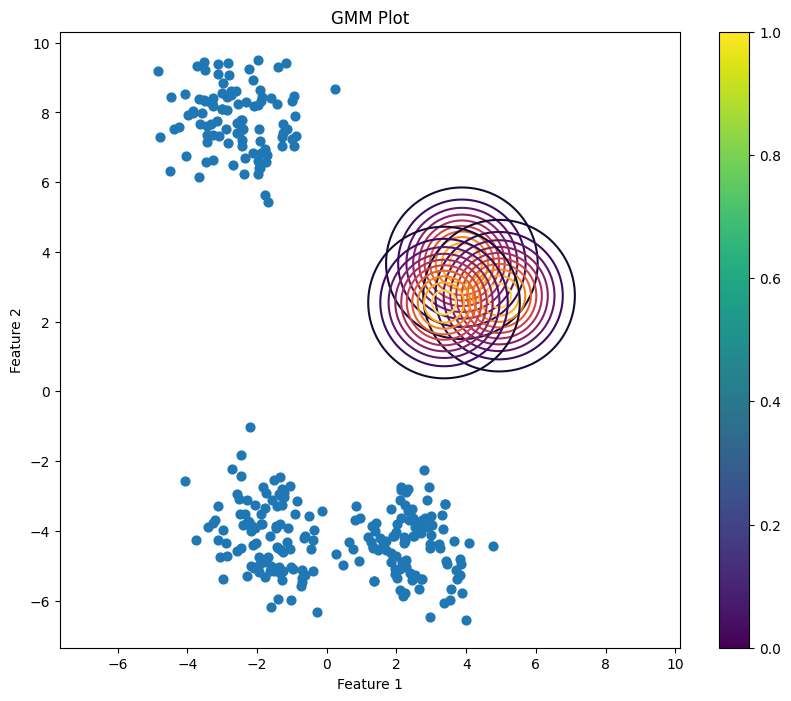

In [287]:
mean, cov, wt = generate_gaussian_parameters(3,2)
plot_multiple_contours(mean, cov,X)


In [300]:
for i in range(3):
    # expectation step
    resp_ = calc_responsibillities(mean,cov, wt,X)
    # maximization step
    wt, mean, cov = update_parameters(resp_, wt,mean, cov, X)
    plot_multiple_contours_gif(mean, cov, X, i)


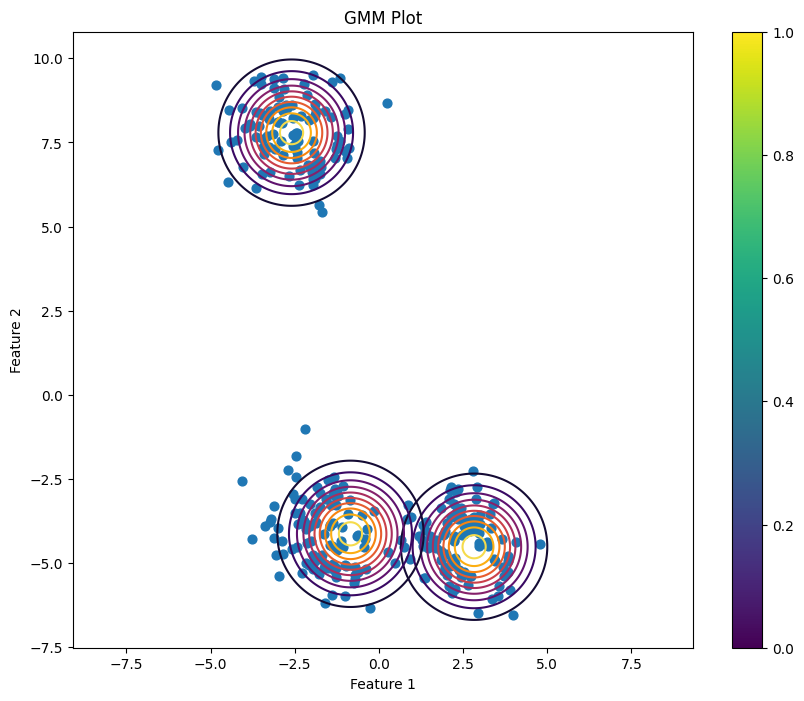

In [289]:
plot_multiple_contours(mean, cov,X)

- We see that the gaussian curves have now segeredated the data based on the highest likelihood.

In [290]:
probs_= calc_responsibillities(mean, cov, wt, X)

In [291]:
probs_[33]

array([1.00000000e+00, 1.03147909e-33, 3.22394163e-26])

- Point 33 has the highest probability of belonging to cluster 1
- Since the data points are such distinclty separable hence the clear difference between the probabilities.